# Library

In [1]:
#Pytorch library
import torch
import torch.nn as nn
from torch import optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Reproducible random
torch.manual_seed(12345)

# Data preprocessing

In [2]:
def normalize_dataset(x, y):
  x_mean = torch.mean(x)
  y_mean = torch.mean(y)
  x_std = torch.std(x)
  y_std = torch.std(y)
  x = (x-torch.mean(x))/torch.std(x)
  y = (y-torch.mean(y))/torch.std(y)
  return x, y, x_mean, y_mean, x_std, y_std

def normalize_input(x, x_mean, x_std):
  return (x-x_mean)/x_std

def denormalize_output(y, y_mean, y_std):
  return y*y_std+y_mean

def slice_dataset(x_dataset, y_dataset, n_train_percent):
  data_size = len(x_dataset)
  x_train = x_dataset[:int(data_size*n_train_percent)]
  x_test = x_dataset[int(data_size*n_train_percent):]
  y_train = y_dataset[:int(data_size*n_train_percent)]
  y_test = y_dataset[int(data_size*n_train_percent):]
  return x_train, y_train, x_test, y_test

# power flow dataset

In [3]:
df = pd.read_excel('dataset.xlsx')

In [4]:
dataset_length = len(df.index)

x_raw, y_raw = [], []
for i in range(dataset_length):
  x_raw.append(df.iloc[i, 1:-6])
  y_raw.append(df.iloc[i, -6:])

x_raw = torch.tensor(x_raw, dtype=torch.float)
y_raw = torch.tensor(y_raw, dtype=torch.float)

In [5]:
n_train_percent = 0.8
x_raw_train, y_raw_train, x_raw_test, y_raw_test = slice_dataset(x_raw, y_raw, n_train_percent)

x, y, x_mean, y_mean, x_std, y_std = normalize_dataset(x_raw, y_raw)

x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
y = torch.where(torch.isnan(y), torch.zeros_like(y), y)

x_train, y_train, x_test, y_test = slice_dataset(x, y, n_train_percent)

# NN 1 layer

In [6]:
input_size = 12
hidden_layer = 16
output_size = 6

model = nn.Sequential(
    nn.Linear(input_size, hidden_layer),
    nn.ReLU(),
    nn.Linear(hidden_layer, output_size)
)

print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

Sequential(
  (0): Linear(in_features=12, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=6, bias=True)
)


In [7]:
train_loss_list, test_loss_list = [], []

for i in range(3001):
  model.train()
  optimizer.zero_grad()
  y_train_prediction = model(x_train)
  train_loss = criterion(y_train_prediction, y_train)
  train_loss.backward()
  optimizer.step()
  train_loss_list.append(train_loss.detach().item())
    
  model.eval()
  y_test_prediction = model(x_test)
  test_loss = criterion(y_test_prediction, y_test)
  test_loss_list.append(test_loss.detach().item())
    
  if (i % 300) == 0:
    print("epoch #" + str(i) + " train loss: " + str(train_loss) + " test loss: " + str(test_loss))

epoch #0 train loss: tensor(1.2306, grad_fn=<MseLossBackward>) test loss: tensor(1.1340, grad_fn=<MseLossBackward>)
epoch #300 train loss: tensor(0.0065, grad_fn=<MseLossBackward>) test loss: tensor(0.0041, grad_fn=<MseLossBackward>)
epoch #600 train loss: tensor(0.0062, grad_fn=<MseLossBackward>) test loss: tensor(0.0039, grad_fn=<MseLossBackward>)
epoch #900 train loss: tensor(0.0058, grad_fn=<MseLossBackward>) test loss: tensor(0.0037, grad_fn=<MseLossBackward>)
epoch #1200 train loss: tensor(0.0044, grad_fn=<MseLossBackward>) test loss: tensor(0.0030, grad_fn=<MseLossBackward>)
epoch #1500 train loss: tensor(0.0015, grad_fn=<MseLossBackward>) test loss: tensor(0.0012, grad_fn=<MseLossBackward>)
epoch #1800 train loss: tensor(0.0007, grad_fn=<MseLossBackward>) test loss: tensor(0.0006, grad_fn=<MseLossBackward>)
epoch #2100 train loss: tensor(0.0005, grad_fn=<MseLossBackward>) test loss: tensor(0.0005, grad_fn=<MseLossBackward>)
epoch #2400 train loss: tensor(0.0004, grad_fn=<MseLos

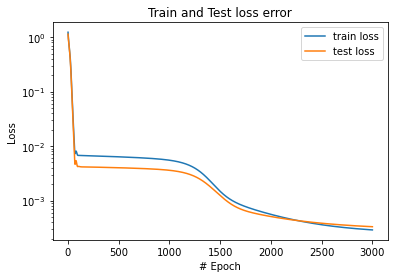

In [8]:
plt.title('Train and Test loss error')
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [9]:
y_train_prediction = model.forward(x_train)
train_loss = torch.mean((y_train - y_train_prediction)**2).detach().item()

print("train output: \n" + str(denormalize_output(y_train, y_mean, y_std)[:3]))
print("train output prediction: \n" + str(denormalize_output(y_train_prediction, y_mean, y_std)[:3]))
print("train loss: " + str(train_loss))

print("----------------------------------------------------------------------")

y_test_prediction = model.forward(x_test)
test_loss = torch.mean((y_test - y_test_prediction)**2).detach().item()

print("test output: \n" + str(denormalize_output(y_test, y_mean, y_std)[-3:]))
print("test output prediction: \n" + str(denormalize_output(y_test_prediction, y_mean, y_std)[-3:]))
print("test loss: " + str(test_loss))

train output: 
tensor([[ 68.1540,  22.9530, 163.0000,   5.9100,  85.0000, -11.2270],
        [ 65.1980,  28.6150, 163.0000,   6.4940,  85.0000, -11.0550],
        [ 73.8900,  24.5100, 163.0000,   6.4930,  85.0000,  -9.9470]])
train output prediction: 
tensor([[ 67.9708,  26.5528, 163.5216,   5.6531,  85.1480, -11.6428],
        [ 65.3024,  26.9993, 162.0398,   6.4366,  84.9023, -10.8083],
        [ 73.7839,  27.0943, 163.1543,   6.4837,  85.0133, -11.0186]],
       grad_fn=<SliceBackward>)
train loss: 0.0002883441629819572
----------------------------------------------------------------------
test output: 
tensor([[ 59.7800,  27.1710, 163.0000,   5.1010,  85.0000, -12.4110],
        [ 84.1720,  25.8880, 163.0000,   5.7580,  85.0000, -11.0430],
        [ 63.1330,  26.1500, 163.0000,   6.5280,  85.0000, -10.5690]])
test output prediction: 
tensor([[ 59.7595,  26.3312, 162.7504,   5.3903,  85.0980, -11.6482],
        [ 84.0142,  27.1939, 164.5346,   6.5152,  85.1538, -11.2968],
        [ 

# NN 2 layer

In [10]:
input_size = 12
hidden_layer = [32, 16]
output_size = 6

model = nn.Sequential(
    nn.Linear(input_size, hidden_layer[0]),
    nn.ReLU(),
    nn.Linear(hidden_layer[0], hidden_layer[1]),
    nn.ReLU(),
    nn.Linear(hidden_layer[1], output_size)
)

print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

Sequential(
  (0): Linear(in_features=12, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=6, bias=True)
)


In [11]:
train_loss_list, test_loss_list = [], []

for i in range(1001):
  model.train()
  optimizer.zero_grad()
  y_train_prediction = model(x_train)
  train_loss = criterion(y_train_prediction, y_train)
  train_loss.backward()
  optimizer.step()
  train_loss_list.append(train_loss.detach().item())
    
  model.eval()
  y_test_prediction = model(x_test)
  test_loss = criterion(y_test_prediction, y_test)
  test_loss_list.append(test_loss.detach().item())
    
  if (i % 100) == 0:
    print("epoch #" + str(i) + " train loss: " + str(train_loss) + " test loss: " + str(test_loss))

epoch #0 train loss: tensor(1.0065, grad_fn=<MseLossBackward>) test loss: tensor(0.9308, grad_fn=<MseLossBackward>)
epoch #100 train loss: tensor(0.0070, grad_fn=<MseLossBackward>) test loss: tensor(0.0046, grad_fn=<MseLossBackward>)
epoch #200 train loss: tensor(0.0067, grad_fn=<MseLossBackward>) test loss: tensor(0.0045, grad_fn=<MseLossBackward>)
epoch #300 train loss: tensor(0.0062, grad_fn=<MseLossBackward>) test loss: tensor(0.0043, grad_fn=<MseLossBackward>)
epoch #400 train loss: tensor(0.0053, grad_fn=<MseLossBackward>) test loss: tensor(0.0039, grad_fn=<MseLossBackward>)
epoch #500 train loss: tensor(0.0033, grad_fn=<MseLossBackward>) test loss: tensor(0.0029, grad_fn=<MseLossBackward>)
epoch #600 train loss: tensor(0.0011, grad_fn=<MseLossBackward>) test loss: tensor(0.0011, grad_fn=<MseLossBackward>)
epoch #700 train loss: tensor(0.0004, grad_fn=<MseLossBackward>) test loss: tensor(0.0005, grad_fn=<MseLossBackward>)
epoch #800 train loss: tensor(0.0003, grad_fn=<MseLossBack

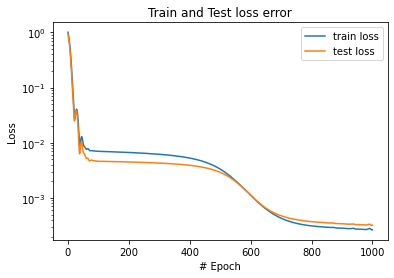

In [12]:
plt.title('Train and Test loss error')
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [13]:
y_train_prediction = model.forward(x_train)
train_loss = torch.mean((y_train - y_train_prediction)**2).detach().item()

print("train output: \n" + str(denormalize_output(y_train, y_mean, y_std)[:3]))
print("train output prediction: \n" + str(denormalize_output(y_train_prediction, y_mean, y_std)[:3]))
print("train loss: " + str(train_loss))

print("----------------------------------------------------------------------")

y_test_prediction = model.forward(x_test)
test_loss = torch.mean((y_test - y_test_prediction)**2).detach().item()

print("test output: \n" + str(denormalize_output(y_test, y_mean, y_std)[-3:]))
print("test output prediction: \n" + str(denormalize_output(y_test_prediction, y_mean, y_std)[-3:]))
print("test loss: " + str(test_loss))

train output: 
tensor([[ 68.1540,  22.9530, 163.0000,   5.9100,  85.0000, -11.2270],
        [ 65.1980,  28.6150, 163.0000,   6.4940,  85.0000, -11.0550],
        [ 73.8900,  24.5100, 163.0000,   6.4930,  85.0000,  -9.9470]])
train output prediction: 
tensor([[ 67.6468,  26.3182, 163.5945,   5.9331,  85.6119, -11.6476],
        [ 65.0710,  27.0614, 162.7308,   6.3084,  84.6595, -10.8957],
        [ 73.4123,  27.0978, 163.0833,   6.3914,  85.1754, -10.9276]],
       grad_fn=<SliceBackward>)
train loss: 0.00026617312687449157
----------------------------------------------------------------------
test output: 
tensor([[ 59.7800,  27.1710, 163.0000,   5.1010,  85.0000, -12.4110],
        [ 84.1720,  25.8880, 163.0000,   5.7580,  85.0000, -11.0430],
        [ 63.1330,  26.1500, 163.0000,   6.5280,  85.0000, -10.5690]])
test output prediction: 
tensor([[ 59.6129,  26.1612, 163.4684,   5.7435,  85.2200, -11.7098],
        [ 83.7636,  27.1053, 163.5450,   6.6776,  85.4633, -11.1597],
        [

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data)

0.weight
tensor([[ 6.2253e-03,  2.7349e-01,  1.3272e-01, -2.8062e-01, -5.0754e-02,
         -8.3531e-02, -7.1097e-02, -7.2658e-03, -8.9633e-02,  1.5575e-01,
         -2.8461e-01,  2.1065e-01],
        [ 3.3196e-02,  1.9445e-01,  8.4777e-02,  1.9898e-01, -2.8434e-01,
          1.5037e-01,  5.7880e-02,  1.8924e-01,  2.7001e-01,  2.6727e-01,
          1.4412e-01,  2.5959e-01],
        [ 3.3896e-02,  1.9374e-01,  4.5880e-02, -2.6492e-01, -5.8033e-02,
         -1.2838e-01,  8.0727e-02, -7.9638e-02, -1.7473e-01, -1.6817e-01,
         -1.5333e-01,  2.4265e-01],
        [-3.0820e-02,  1.3731e-01, -1.3963e-01,  7.2771e-02, -2.7436e-01,
          3.7404e-02, -2.1818e-01,  2.3559e-01, -1.7463e-01,  2.5738e-01,
          1.0173e-01,  1.4840e-01],
        [-2.7282e-01,  2.6352e-01, -1.5328e-01,  9.8202e-02, -5.6618e-02,
          7.6917e-02,  1.7375e-01, -3.2146e-02, -2.2856e-01, -1.5701e-01,
          2.0123e-01,  6.5754e-02],
        [-2.9737e-01,  4.1019e-02,  1.6415e-01,  1.6114e-01,  7.7608e-0